In [ ]:
# flow_analyzer.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import streamlit as st

class FlowAnalyzer:
    #!__init__() 内で self.なしで変数を定義することは可能だが、原則として推奨されない。
    def __init__(self, csv_file, d_micro_to_pix, k_extract_microm_flow, adjust_x_grid, convolve_size_flow):

        self.d_micro_to_pix = d_micro_to_pix
        # self.d_pix_grid = #! 未定義、縦と横で倍率が微妙に異なる
        self.k_extract_grid_flow = 100
        self.k_extract_microm_flow = k_extract_microm_flow
        self.adjust_x_grid = adjust_x_grid
        self.convolve_size_flow = convolve_size_flow
        self.path = csv_file
        self.df = pd.read_csv(self.path, encoding="cp932", skiprows = 7, skipfooter = 0, usecols = range(1,7), index_col = None, header = None, engine = 'python')
        self.flow_ar, self.width_grid, self.height_grid = self._prepare_data()
        #? バブル中心の座標をFE座標系で取得
        self.x0_grid, self.y0_grid = self._generate_grid()
        #? FE座標系でのx座標配列（バブル中心を原点とする）
        self.array_x = np.arange(self.width_grid) - self.x0_grid
        #! 対称軸両側を含む領域への処理
        #? x方向とy方向の流速を、FE座標で取得
        self.flow_vx = self.flow_xy(4)
        self.flow_vy = self.flow_xy(5)
        #? x方向とy方向をフィッティングした流速を、FE座標で取得
        # self.flow_vx_convolve = self.rep_convolve(self.flow_vx, self.valid_convolve, 21)
        self.flow_vy_convolve = self.rep_convolve(self.flow_vy, self.valid_convolve)
        #? x方向とy方向の平滑化をフィッティングした流速を、FE座標で取得
        # self.flow_vx_fit, self.flow_vx_fit_nobug = self.fit_repeat(self.flow_vx)
        self.flow_vy_fit, self.flow_vy_fit_nobug = self.fit_repeat(self.flow_vy)
        #? x方向とy方向の平滑化をフィッティングした流速を、FE座標で取得
        # self.flow_vx_convolve_fit, self.flow_vx_convolve_fit_nobug = self.fit_repeat(self.flow_vx_convolve)
        self.flow_vy_convolve_fit, self.flow_vy_convolve_fit_nobug = self.fit_repeat(self.flow_vy_convolve)
        #? 指定された高さの流速を取得
        self.flow_vy_k, self.k_grid = self.extract_flow(self.flow_vy)
        self.flow_vy_convolve_k, self.k_grid = self.extract_flow(self.flow_vy_convolve)
        self.flow_vy_fit_k, self.k_grid = self.extract_flow(self.flow_vy_fit)
        self.flow_vy_convolve_fit_k, self.k_grid = self.extract_flow(self.flow_vy_convolve_fit)
        #! 対称軸片側（右側）領域への処理
        
        #? x方向とy方向の平滑化した流速を、FE座標で取得
        self.flow_vx_convolve = self.rep_convolve(self.flow_vx, self.valid_convolve)
        self.flow_vy_convolve = self.rep_convolve(self.flow_vy, self.valid_convolve)
        #? x方向とy方向の平滑化をフィッティングした流速を、FE座標で取得
        # self.flow_vx_fit, self.flow_vx_fit_nobug = self.fit_repeat(self.flow_vx)
        self.flow_vy_fit, self.flow_vy_fit_nobug = self.fit_repeat(self.flow_vy)
        #? x方向とy方向の平滑化をフィッティングした流速を、FE座標で取得
        # self.flow_vx_convolve_fit, self.flow_vx_convolve_fit_nobug = self.fit_repeat(self.flow_vx_convolve)
        self.flow_vy_convolve_fit, self.flow_vy_convolve_fit_nobug = self.fit_repeat(self.flow_vy_convolve)
        #? 指定された高さの流速を取得
        self.flow_vy_k, self.k_grid = self.extract_flow(self.flow_vy)
        self.flow_vy_convolve_k, self.k_grid = self.extract_flow(self.flow_vy_convolve)
        self.flow_vy_fit_k, self.k_grid = self.extract_flow(self.flow_vy_fit)
        self.flow_vy_convolve_fit_k, self.k_grid = self.extract_flow(self.flow_vy_convolve_fit)


    #* 読み取ったcsvファイルを、計算に使えるように処理
    def _prepare_data(self):
        df_T = self.df.T
        #? ファイル中の"-"を0に置き換え、各要素をすべてfloat型に変換
        self.df_T_replace = df_T.replace("-", 0.0).astype(float)
        #? numpy配列に変換
        self.flow_ar = self.df_T_replace.to_numpy()
        self.width_grid = int(max(self.flow_ar[0]))  #? FE格子点の横幅を取得
        self.height_grid = int(max(self.flow_ar[1]))  #? FE格子点の高さを取得
        return self.flow_ar, self.width_grid, self.height_grid

    def _generate_grid(self):
        '''
        li = [
            [10, 20, 30],   # li[0] x座標情報
            [1, 2, 3]       # li[1] y座標情報
        ]
        li_gridpoint = list(zip(li[0], li[1]))
        => [(10, 1), (20, 2), (30, 3)]
        '''
        li_gridpoint = list(zip(self.flow_ar[0], self.flow_ar[1])) #? x座標とy座標をベアにしてタプルのリストを作成
        li_coordinates = list(zip(self.flow_ar[2], self.flow_ar[3]))
        li_velocity = list(zip(self.flow_ar[4], self.flow_ar[5]))
        '''
        li_gridpoint   = [(100, 50), (200, 50), (300, 50)] # 実際のグリッド上の座標（物理座標など）
        li_velocity    = [(1.2, 0.1), (1.1, 0.2), (1.0, 0.3)]  # 各点での速度ベクトル
        self.gridpoint_velocity = {
            (100, 50): (1.2, 0.1),
            (200, 50): (1.1, 0.2),
            (300, 50): (1.0, 0.3)
        }
        '''
        #? グリッドポイントと速度ベクトルを結びつける辞書
        self.gridpoint_velocity = {k: v for k, v in zip(li_gridpoint, li_velocity)}
        self.coordinates_gridpoint = {k: v for k, v in zip(li_coordinates, li_gridpoint)}
        #? 座標が(0, 0)のグリッドポイントを取得（バブル中心のグリッドポイントを取得）
        self.x0, self.y0 = map(int, self.coordinates_gridpoint[(0.0, 0.0)])
        return self.x0, self.y0

    #* 流速を取得（FE座標系）
    def flow_xy(self, col):
        arr_1d = self.flow_ar[col]  # 1次元配列
        arr_2d = np.reshape(arr_1d, (self.height_grid, self.width_grid))  # 2次元化
        return arr_2d

    #* 流速に移動平均をかけるときに使用
    def valid_convolve(self, xx, size):
        b = np.ones(size)/size
        xx_mean = np.convolve(xx, b, mode="same")
        n_conv = math.ceil(size/2)
        # 補正部分
        xx_mean[0] *= size/n_conv
        for i in range(1, n_conv):
            xx_mean[i] *= size/(i+n_conv)
            xx_mean[-i] *= size/(i + n_conv - (size % 2))
        # size%2は奇数偶数での違いに対応するため
        return xx_mean

    def rep_convolve(self, li2, func):
        return np.array([func(row, self.convolve_size_flow) for row in li2])

    #* 流速にフィッティングを行う際に使用
    def fit1(self, v_1d):
        def fukuhara_fit(x, a, b, c, d, e):
            return a * np.exp(- (x - b)**2 / (2* c**2)) + d * x + e

        array_y = v_1d # フィッティング対象の流速データ
        popt, _ = curve_fit(
            fukuhara_fit, self.array_x, array_y,
            p0=[0.03, 0.01, 40, 0.001, 0.0001],
            maxfev=20000
        )

        fitted_y = fukuhara_fit(self.array_x, *popt)
        fitted_y_nobg = popt[0] * np.exp(- (self.array_x - popt[1])**2 / (2 * popt[2]**2)) + popt[4]

        return fitted_y, fitted_y_nobg, popt

    def fit_repeat(self, v_2d):
        results = [self.fit1(v_2d[i]) for i in range(self.height_grid)]
        self.ar_flow, self.ar_flow_nobg, self.ar_popt = tuple(np.stack(parts) for parts in zip(*results))
        return self.ar_flow, self.ar_flow_nobg

    def extract_flow(self, ar):
        # k_extract_grid_flow = int(self.k_extract_microm_flow*self.d_micro_to_pix)+self.y0
        # k_extract_grid_flow = self.k_extract_grid_flow
        return ar[self.k_extract_grid_flow-1], self.k_extract_grid_flow

    def fit_convolve(self, v_2d):
        #? 平滑化した流速を、FE座標で取得
        self.flow_v_convolve = self.rep_convolve(v_2d, self.valid_convolve)
        #? フィッティングした流速を、FE座標で取得
        self.flow_v_fit, self.flow_v_fit_nobug = self.fit_repeat(v_2d)
        #? 平滑化をフィッティングした流速を、FE座標で取得
        self.flow_v_convolve_fit, self.flow_v_convolve_fit_nobug = self.fit_repeat(v_2d)
        combined = [
            self.flow_v_convolve,
            self.flow_v_fit,
            self.flow_v_convolve_fit,
            self.flow_v_convolve_fit_nobug
        ]
        #? 指定された高さの流速を取得
    #     self.flow_vy_k, self.k_grid = self.extract_flow(self.flow_vy)
    #     self.flow_vy_convolve_k, self.k_grid = self.extract_flow(self.flow_vy_convolve)
    #     self.flow_vy_fit_k, self.k_grid = self.extract_flow(self.flow_vy_fit)
    #     self.flow_vy_convolve_fit_k, self.k_grid = self.extract_flow(self.flow_vy_convolve_fit)


    '''
    #! 球面上の流速を計算するメソッド群
    def compute_theta_vr(self, r_min, r_max):
        di = {}
        number = 0
        for key, value in self.gridpoint_velocity.items():
            x = key[0] - self.x0
            y = key[1] - self.y0
            r = math.sqrt(x**2 + y**2)
            if y > 0 and r_min <= r <= r_max:
                theta = math.degrees(math.atan2(x, y))
                vr = value[0]*math.sin(math.radians(theta)) + value[1]*math.cos(math.radians(theta))
                di[theta] = vr
                number += 1
        self.theta_vr = di
        return di, number

    def plot_flow(self):
        dic = self.theta_vr
        x, y = zip(*sorted(dic.items()))
        fig = plt.figure()
        plt.plot(x, y, label='測定データ', marker='o', lw=0)
        plt.xlabel("バブル中心軸からの角度[°]", fontname="MS Gothic")
        plt.ylabel("流速[μm/μs]", fontname="MS Gothic")
        plt.legend()
        st.pyplot(fig)

    def plot_approximation(self):
        def sincos_fit(x, a, b, c, d):
            return -a * np.sin(np.radians(b * x + c)) * np.cos(2 * np.radians(b * x + c)) + d

        dic = self.theta_vr
        array_x = np.array(list(dic.keys()))
        array_y = np.array(list(dic.values()))

        popt, _ = curve_fit(sincos_fit, array_x, array_y, p0=[0.03, 1, 90, 0])

        fitted_y = [sincos_fit(x, *popt) for x in array_x]
        fig = plt.figure()
        plt.plot(array_x, array_y, label='測定データ', marker='o', lw=0)
        plt.plot(array_x, fitted_y, label='近似曲線', lw=3)
        plt.xlabel("バブル中心軸からの角度[°]", fontname="MS Gothic")
        plt.ylabel("流速[μm/μs]", fontname="MS Gothic")
        plt.legend()
        st.pyplot(fig)

    def generate_report(self, r_min, r_max, number):
        r_min_um = r_min / self.d_micro_to_pix
        r_max_um = r_max / self.d_micro_to_pix
        report = (
            f"バブル原点のx座標: {self.x0} [pix]\n"
            f"バブル原点のy座標: {self.y0} [pix]\n"
            f"プロットするデータの個数: {number}\n"
            f"取得する半径の範囲: {r_min} <= r <= {r_max} [pix]\n"
            f"取得する半径の範囲: {r_min_um:.2f} <= r <= {r_max_um:.2f} [μm]"
        )
        return report
    '''



In [101]:
uploaded_file = r"sample.csv"
d_micro_to_pix = 1.0269 #*流速分布観察カメラの1umあたりのpixel d[pixel/μm]
k_extract_microm_flow = 100 #*流速分布観察で抽出するy座標の高さ [μm]
adjust_x_grid = 0 #*グリッドのx座標を調整する値 [pix]
convolve_size_flow = 21 #*流速分布観察での平滑化に使用するカーネルサイズ [pix]

In [102]:
flow = FlowAnalyzer(uploaded_file, d_micro_to_pix, k_extract_microm_flow, adjust_x_grid, convolve_size_flow)
# # print(flow.df_flow)
# # flow.df_flow
# flow.df_T_replace

C:\Users\seiji\AppData\Local\Temp\ipykernel_23836\1698536586.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df_T_replace = df_T.replace("-", 0.0).astype(float)


In [103]:
print(flow.width_grid)
print(flow.height_grid)


350
234


In [104]:
# print(type(flow.flow_vy_fit))  # ← None であれば未設定です
# print(flow.flow_vy_fit)  # ← None であれば未設定です
print(flow.flow_vy_k)  # ← None であれば未設定です
print(flow.k_grid)  # ← None であれば未設定です

[-1.4330e-03 -1.3100e-03 -1.5660e-03 -1.5430e-03 -1.5270e-03 -1.4790e-03
 -1.4820e-03 -1.5840e-03 -1.6050e-03 -1.5820e-03 -1.5920e-03 -1.6240e-03
 -1.5900e-03 -1.6350e-03 -1.6580e-03 -1.6610e-03 -1.6710e-03 -1.6620e-03
 -1.6900e-03 -1.7040e-03 -1.6840e-03 -1.7060e-03 -1.7270e-03 -1.7180e-03
 -1.7450e-03 -1.7490e-03 -1.7320e-03 -1.7440e-03 -1.7660e-03 -1.7660e-03
 -1.7930e-03 -1.8100e-03 -1.7910e-03 -1.8260e-03 -1.8360e-03 -1.8220e-03
 -1.8400e-03 -1.8450e-03 -1.8230e-03 -1.8400e-03 -1.8420e-03 -1.8390e-03
 -1.8470e-03 -1.8600e-03 -1.8560e-03 -1.8580e-03 -1.9410e-03 -1.9740e-03
 -2.0360e-03 -2.0580e-03 -2.0400e-03 -2.0240e-03 -2.0420e-03 -2.0940e-03
 -2.0720e-03 -2.1230e-03 -2.1180e-03 -2.1430e-03 -2.1090e-03 -2.2060e-03
 -2.1810e-03 -2.1670e-03 -2.2600e-03 -2.2270e-03 -2.2920e-03 -2.2560e-03
 -2.3000e-03 -2.3120e-03 -2.3650e-03 -2.4120e-03 -2.3800e-03 -2.3870e-03
 -2.4030e-03 -2.3700e-03 -2.3870e-03 -2.4000e-03 -2.4640e-03 -2.4220e-03
 -2.5340e-03 -2.5320e-03 -2.5580e-03 -2.5460e-03 -2

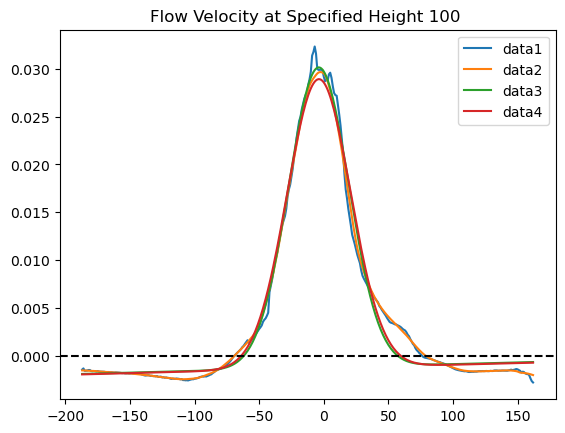

In [105]:
plt.plot(flow.array_x, flow.flow_vy_k, label="data1")
plt.plot(flow.array_x, flow.flow_vy_convolve_k, label="data2")
plt.plot(flow.array_x, flow.flow_vy_fit_k, label="data3")
plt.plot(flow.array_x, flow.flow_vy_convolve_fit_k, label="data4")
plt.axhline(y=0, color='k', linestyle='--')  # vy=0の水平線を引く
plt.legend(loc='upper right',fontsize = 9)
plt.tick_params(labelsize=10)
plt.title(f"Flow Velocity at Specified Height {flow.k_grid} ")
plt.legend()
plt.show()


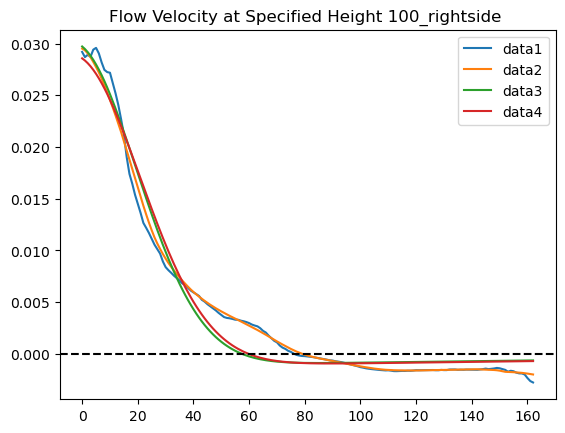

In [106]:

x_right_half_grid = flow.x0_grid + flow.adjust_x_grid
plt.plot(flow.array_x[x_start_grid:], flow.flow_vy_k[x_start_grid:], label="data1")
plt.plot(flow.array_x[x_start_grid:], flow.flow_vy_convolve_k[x_start_grid:], label="data2")
plt.plot(flow.array_x[x_start_grid:], flow.flow_vy_fit_k[x_start_grid:], label="data3")
plt.plot(flow.array_x[x_start_grid:], flow.flow_vy_convolve_fit_k[x_start_grid:], label="data4")
plt.title(f"Flow Velocity at Specified Height {flow.k_grid}_rightside ")
plt.axhline(y=0, color='k', linestyle='--')  # vy=0の水平線を引く
plt.legend(loc='upper right',fontsize = 9)
plt.tick_params(labelsize=10)
plt.legend()
plt.show()